In [1]:
import glob
import os
import ast
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd


directory = '/scratch/6256481/'
os.chdir(directory + 'python/py_code')
from inflection_points import inflection_points
from support import open_mg_file, create_dir


import warnings
warnings.filterwarnings("ignore")

# Open functions

In [2]:
def change_str_list(df, cols):
    for index, row in df.iterrows():
            for col in cols:
                if col == 'mOISlope':
                    newRow = df.loc[index]
                    vals   = newRow.outSlope
                    # print(1, vals)
                    if isinstance(vals, np.ndarray) == False:
                        vals = []
                    # print(2, vals)
                    val2 = newRow.innSlope
                    if isinstance(val2, list):
                        # print(vals, val2)
                        vals.extend(val2)

                    df.loc[index, col] = np.nanmean(vals)
                else:
                     
                    try:
                        if isinstance(row[col] ,str) == True:
                            # print(1)
                            R = row[col]
                            R = R.replace('nan', '99999') 
                            listVal = ast.literal_eval(R)

                            # check if slope val is nested list
                            if isinstance(listVal[0], list):
                                listVal = listVal[0]
                            

                            # check if slope val is single value --> not a list
                            if isinstance(listVal, int):
                                listVal = [listVal]
                            # print(col, listVal)
                            
                            if col == 'CDists': #change after new run with correct distance values
                                listVal = np.array([np.nan])
                            else:
                                listVal = np.array(listVal)
                            vals = listVal
                            
                            vals = vals.astype(float)
                            vals[vals == 99999] = np.nan
                            # print(4, vals)
                            
                            # df.loc[index, col]    = vals
                            df.at[index, col] = vals
                            # print(4.1)
                            df.loc[index, f'm{col}']   = np.nanmean(vals)
                            # print(4.2)
                            df.loc[index, f'max{col}'] = np.nanmax(vals)
                            # print(5)
                        else:
                            vals = np.nan
                            df.loc[index, f'{col}']    = vals
                            df.loc[index, f'm{col}']   = vals
                            df.loc[index, f'max{col}'] = vals

                    except:
                        print('except??')
                        df.at[index, f'{col}']     = np.nan
                        df.loc[index, f'm{col}']   = np.nan
                        df.loc[index, f'max{col}'] = np.nan

    return df

In [3]:
def open_all_files(save_all, save_individual, FA, F_slice):
    for i in range(len(FA)):
        fa = FA[i][F_slice[0]:F_slice[1]]
        print(fa)
        # print(fa[i])
        
        df = open_mg_file(FA[i], 'EPSG:3857')

        
        
        df = change_str_list(df, ['outSlope', 'innSlope', 'outPR', 'innPR', 'CDists', 'mOISlope'])
        df.loc[:, 'File'] = fa
        df['outSlopeRatio'] = (df['moutSlope'] - df['slope']) / (((df['moutSlope'] + df['slope'])/2))
        df['innSlopeRatio'] = (df['minnSlope'] - df['slope']) / (((df['minnSlope'] + df['slope'])/2))
        
        if i > 0:
            dfT = pd.concat([dfT, df])
        else:
            dfT = df

        if save_individual == True:
            cols = [ 'reach_id',  'slope', 'geometry',
                    'Cycle1',
                    'sin10_2', 'sin10_5', 'sinReg10_2', 'sinReg10_5', 'sin20_2',
                    'sin20_5', 'sinReg20_2', 'sinReg20_5', 'vc', 'moutSlope', 'maxoutSlope',
                    'minnSlope', 'maxinnSlope', 'moutPR', 'maxoutPR', 'minnPR', 'maxinnPR',
                    'mCDists', 'maxCDists', 'File']
            save_individual_folder = directory + 'results/conf'
            create_dir(save_individual_folder)
            df_inv = df.copy()
            if 'Cycle1' not in df.columns:
                print('yes')
            # for c in df_inv.columns:
            #     print(c)

            # df_inv = df_inv[cols]
            # for c in df_inv.columns:
            #     print(c)
            # return df_inv
            # print(type(df_inv))
            # df_inv.to_file(save_individual_folder + f'/{fa}.shp')
    
    if save_all == True:
        dfT.to_csv(directory + 'results/all/All_conf.csv')

    return dfT

results_created = glob.glob(directory + 'results/all/*as*44*_5_*.csv')
ex = glob.glob(directory + 'results/all/*sa*62*_5_*.csv')
results_created.extend(ex)
df = open_all_files(False, True, results_created  , [-16, -11])


as_44
sa_62


# Open Nodes

In [9]:
F  = glob.glob(directory + 'results/new_segments/node/*as*44*.shp')
F1 = glob.glob(directory + 'results/new_segments/node/*sa*62*.shp')
F.extend(F1)
F

['/scratch/6256481/results/new_segments/node/as_44_new_segments_node.shp',
 '/scratch/6256481/results/new_segments/node/sa_62_new_segments_node.shp']

In [10]:
# Open node files
df_node = gpd.read_file(F[0])
D = gpd.read_file(F[1])
df_node = pd.concat([df_node, D])

In [34]:
V = df[df.reach_id == 44102000191]
NID = np.array(V[['reach_id','rch_ids_up', 'rch_ids_dn']].iloc[0].values).astype(str)
NID = NID[NID != 'nan'].astype(int)
NID

array([44102000191])

<Axes: >

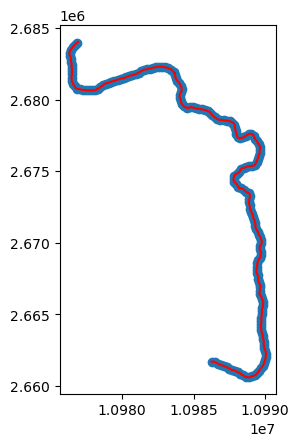

In [35]:
I = 44547500211
V = df[df.reach_id == I]

VI = np.array(V[['reach_id','rch_ids_up', 'rch_ids_dn']].iloc[0].values).astype(str)
VI = VI[VI != 'nan'].astype(int)
N = df_node[df_node.reach_id.isin(VI)]

f, ax = plt.subplots()
N.plot(ax = ax)
V.plot(ax = ax, color = 'red')


# Inflection function

In [38]:
from smoothing import SG_smoothing
from calc_functions import minmax
from line_functions import azimuth_coords, getExtrapoledLine, remove_self_intersect


import shapely
from shapely.geometry import Point, LineString, MultiPolygon
import geopandas as gpd

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [106]:

def inflection_points_test(ids, df_vector, df_node,projection, plot = True, s = 10, degree = 1, end_points = False):  
    """
    Input:
    ids: row reach ID
    dataframe: vector Dataframe
    projection: Selected projection (standard mercator global)
    plot: boolean value to plot or not, default = True
    s: smoothing window, default = 10
    degree: minimal angle difference for inflection, default = 1
    end_points: include end_points of linestring as inflection points, default = False
    
    return:
        sinuosity: single value for the sinuosity based on length / inflection length
        sin_reg: regularity of the distance between inflection points (std)
        gdf_inf.geometry.values: array of inlfection points as shapely points
        apex: list of distances to apex points
        apex_points: list of apex points (shapely points)
        find_apex_vals: list of distances from inflection line to centerline
    """
    # Select dataframe row and dataframe nodes
    
    r         = df_vector[df_vector.reach_id == ids] # select dataframe row
    line_orig = r.geometry
    r.loc[:,'geometry'] = remove_self_intersect(r.iloc[0].geometry)


    node_ids  = np.array(r[['reach_id','rch_ids_up', 'rch_ids_dn']].iloc[0].values).astype(str)
    node_ids  = node_ids[node_ids != 'nan'].astype(int)
    node_rows = df_node[df_node.reach_id.isin(node_ids)]
    

    smoothing_window = s*int(r.iloc[0].node_mwm)               # define smoothing window based on mean node max width
    length_ratio     = r.iloc[0].reach_len / r.iloc[0].min_len # Length ratio reach length and minimum required length
    
    if length_ratio < 1.0: # If length ratio is below 1 the smoothing window is multiplied by the ratio
        smoothing_window *= length_ratio
        
    # Smooth the initial line and change dataframe to Series
    r.loc[:,'geometry'] = SG_smoothing(r.iloc[0].geometry, smoothing_window, False).simplify(0.5, preserve_topology=True)
    
    
    if len(r.loc[:,'geometry'].iloc[0].coords) < 3:
        r.loc[:,'geometry'] = r.loc[:,'geometry'].iloc[0].segmentize(500) 
    
    row                 = r.iloc[0]

    vector     = row.geometry  # Select geometry
    vec_coords = vector.coords # Get coordinates in the line segment

        
    # empty lists to be used in loop
    crosses          = []
    fwd              = []
    
    # loop over all the coordinates minus two. the minus two is to be able to find coordinates before and after the selected point
    for c in range(len(vec_coords) -2):

        # Select the target coordinate pair and select point before and after
        target_min  = vec_coords[c]
        target      = vec_coords[c+1]
        target_plus = vec_coords[c+2]
        
        
        # Calculate direction between 
        fwd_azimuth_minus = azimuth_coords(target_min[0], target_min[1],target[0], target[1])
        fwd_azimuth_plus  = azimuth_coords(target[0], target[1],target_plus[0], target_plus[1])
        fwd.append((fwd_azimuth_minus + fwd_azimuth_plus) / 2)

        # Calculate cross product between points
        v1 = np.array(target) - np.array(target_min)
        v2 = np.array(target_plus) - np.array(target)
        crosses.append((v1[0] * v2[1]) - (v1[1] * v2[0]))
        

    # Create dataframe with cross products and coordinate id's
    new_df = pd.DataFrame({'id':np.arange(0,len(vec_coords)-2), 'cross':crosses, 'fwd':fwd})

    # get the coordinates for the points 
    new_df[['Xm', 'Ym']] = r.get_coordinates().values[0:-2]
    new_df[['X', 'Y']]   = r.get_coordinates().values[1:-1]
    new_df[['Xp', 'Yp']] = r.get_coordinates().values[2::]
    
    new_df.loc[:,'change']  = np.sign(new_df.cross).diff().ne(0) # check rows where cross product changes sign
    
    new_df.loc[:,'change_pX'] = (new_df.Xm + new_df.X) / 2 # find the point between two points
    new_df.loc[:,'change_pY'] = (new_df.Ym + new_df.Y) / 2 # find the point between two points

    # fist change px and py is not real first point
    if end_points == True:
        new_df.loc[new_df.index[0], 'change_pX'] = new_df.loc[new_df.index[0], 'Xm']
        new_df.loc[new_df.index[0], 'change_pY'] = new_df.loc[new_df.index[0], 'Ym']
        
        end_true = new_df.iloc[-1].change
        if end_true == True:
            new_df.loc[new_df.index[-1] + 1, :] = new_df.loc[new_df.index[-1], :]
            new_df.loc[new_df.index[-1], 'change'] = True
            new_df.loc[new_df.index[-1], 'id'] += 1

            new_df.loc[new_df.index[-1], 'fwd'] = 1e3
            new_df.loc[new_df.index[-1], 'change_pX'] = new_df.loc[new_df.index[-1], 'Xp']
            new_df.loc[new_df.index[-1], 'change_pY'] = new_df.loc[new_df.index[-1], 'Yp']
        else:
            new_df.loc[new_df.index[-1], 'change'] = True
            new_df.loc[new_df.index[-1], 'change_pX'] = new_df.loc[new_df.index[-1], 'Xp']
            new_df.loc[new_df.index[-1], 'change_pY'] = new_df.loc[new_df.index[-1], 'Yp']
            new_df.loc[new_df.index[-1], 'fwd'] = 1e3

    else:
        new_df.loc[new_df.index[0], 'change'] = False

    # Get only values where there is a change in cross-product --> if end points is true these are changed to true 
    inflections = new_df[new_df.change == True]
    inflections = inflections.copy() # get copy of dataframe to remove chaining errors
    
    # check the difference in angle with the previous inflection point
    inflections.loc[:,'fwd_change'] = abs(inflections.fwd.diff().values)
    
    # set the first value to a high value --> no calculation possible
    inflections.loc[inflections.index[0], 'fwd_change'] = 100
    
    # remove inflection points where the difference in angle with the previous inflection point is too small
    inflections = inflections[inflections.fwd_change > degree]
    
    ############################################
    # Sinuosity
    ############################################      
    if inflections.shape[0] > 1:
        gdf_inf = gpd.GeoDataFrame(
                inflections, geometry=gpd.points_from_xy(inflections.change_pX, inflections.change_pY), 
                crs=projection)
        inf_line = LineString(gdf_inf.geometry)

        reg_inf   = gdf_inf.copy()
        sinuosity = vector.length / inf_line.length
        
        # if regularity is not calculated for the added final node use below code
        # if end_points == True:
        #     sinuosity = vector.length / inf_line.length

        #     if end_true == False:
        #         reg_inf = reg_inf.iloc[1:-1, :]
        #     else:
        #         reg_inf = reg_inf.iloc[1::, :]
        # else:
        #     vector_length = vector.project(gdf_inf.iloc[-1].geometry) - vector.project(gdf_inf.iloc[0].geometry)
        #     sinuosity     = vector_length / inf_line.length

        ############################################
        # regularity calculation
        ############################################      
        if reg_inf.shape[0] >= 3:
            # print('number of inflections', reg_inf.shape[0])
            sin = [] 
            inf_lines = []
            for i in range(reg_inf.shape[0]-1):
        
                p1 = reg_inf.iloc[i].geometry
                p2 = reg_inf.iloc[i+1].geometry
                along_dist = vector.project(p2)-vector.project(p1)
                
                straight_line = LineString([p1,p2])
                inf_lines.append(straight_line)
                sin.append(along_dist / straight_line.length)

            # min max scaling:

            scaled_sin = minmax(sin)
            sin_reg    = np.std(scaled_sin)
        else:
            sin_reg = np.nan

        ############################################
        # Meander apexs and amplitudes
        ############################################
        apex            = []  # Apex distances
        apex_points     = []  # apex points
        find_apex_vals  = []  # list of values used to locate the apex
        segs            = np.linspace(0.1,0.9,10) # segments used for locating apex (discard first and last 10%)

        sin_reg_angles = []
        for i in range(gdf_inf.shape[0]-1):
         
            l = LineString([gdf_inf.iloc[i].geometry,gdf_inf.iloc[i+1].geometry]) # inflection segments

            # cut the river line in sections corresponding to the inflection section
            p1 = Point(l.coords[0]).buffer(1)
            p2 = Point(l.coords[-1]).buffer(1)
            p = MultiPolygon([p1,p2])
            vectorSplit = shapely.ops.split(vector, p)
            

            # plt.plot(*l.xy)

            for j in range(len(vectorSplit.geoms)):
                i1 = vectorSplit.geoms[j].buffer(2).intersects(p1)
                i2 = vectorSplit.geoms[j].buffer(2).intersects(p2)

                if (i1) & (i2):
                    alongSectionId = j
                    
            #     if j == 5:
            #         continue
            #     plt.plot(*vectorSplit.geoms[j].xy, label = j)
            # plt.plot(*p1.exterior.xy, label = 'p1')
            # plt.plot(*p2.exterior.xy, label = 'p2')
            # plt.legend()
            # plt.title(f'{s}, {degree}')
            # plt.show()
            
            
            alongSection = vectorSplit.geoms[alongSectionId]
            
            # f, ax  = plt.subplots()
            # ax.set_aspect('equal')
            num_points, end_buff = np.array(str(np.round(alongSection.length / 200, 2)).split(".")).astype(int)
            points = []
            normalized_delta_angles =[]
            for p in range(num_points):
                start = (((end_buff/100)*200)/2) + 100
                points.append(alongSection.interpolate(start + (p*200)))

                if p > 1:
                    target_min  = points[p-2].coords[0]
                    target      = points[p-1].coords[0]
                    target_plus = points[p].coords[0]

        
                    # Calculate direction between 
                    fwd_azimuth_minus = azimuth_coords(target_min[0], target_min[1],target[0], target[1])
                    fwd_azimuth_plus  = azimuth_coords(target[0], target[1],target_plus[0], target_plus[1])
                    diff = abs(fwd_azimuth_minus - fwd_azimuth_plus)
                    # Adjust if the difference is greater than 180 degrees
                    if diff > 180:
                        diff = 360 - diff

                    normalized_delta_angles.append(diff * (alongSection.length / r.iloc[0].geometry.length))
            sin_reg_angles.extend(normalized_delta_angles)
            #     plt.scatter(*points[p].xy)

            # ax.plot(*alongSection.xy)
            # plt.show()





            # parallel sections for determining the orthogonal line
            ll = l.parallel_offset(1)
            lr = l.parallel_offset(-1)
            
            A = []           # Possible apex points
            B = []           # positions on the inflection line segments
            C = np.zeros(10) # Possible apex distances (amplitudes)
            for j in range(len(segs)):
                dist = 10
                apex_int = False
                while apex_int == False:
                    apex_line = getExtrapoledLine(list(ll.interpolate(segs[j], normalized=True).coords)[0],
                                        list(lr.interpolate(segs[j], normalized=True).coords)[0], 
                                        dist, 2, single = False)
                    dist *=2
                    apex_int = apex_line.intersects(alongSection)
                    
                
                A.append(shapely.ops.nearest_points(apex_line, alongSection)[1])
                B.append(l.interpolate(segs[j],normalized = True))
                C[j] = A[j].distance(B[j])
                
            find_apex_vals.extend(C)
            apex.append(C.max())
            apex_points.append(A[np.argmax(C)])
    else:
        sinuosity = 0.00
        sin_reg   = 0.00
    
    
    # plt.show()
    if plot == True:
        plt.figure(figsize=  [6,4])
        tl1 = f'Sinuosity: {np.round(sinuosity,8)}_Regularity: {np.round(sin_reg,8)}'
        tl2 = f'mean apex: {np.round(np.mean(apex))}, Norm std Apex: {np.round(np.std(minmax(apex)),8)}'
        tl3 = f'Window: {s}, width: {int(row.node_mwm)}, Degree: {degree}'
        plt.title(f'id: {ids}\n{tl1}\n{tl2}\n{tl3}')
        # plt.plot(*row.geometry.xy)
        plt.plot(*vector.xy, color = 'orange', zorder = 0)
        
        if inflections.shape[0] > 1:
            plt.plot(*inf_line.xy, c = 'g', zorder = 10)
        
        for p in gdf_inf.geometry:
            plt.scatter(*p.xy, c = 'r', zorder= 20, s = 10)

        for ap in apex_points:
            plt.scatter(*ap.xy, marker = '^', c = 'b', s = 5, zorder = 20)
        
        plt.axis('equal')
        plt.axis('off')
        plt.show()

    print(np.std(sin_reg_angles))
    return(sinuosity, sin_reg   , list(gdf_inf.geometry.values), apex     , apex_points, find_apex_vals)
        #  Sinuosity, Regularity, Inflection points      , Amplitude, Apex points, List of possible amplitude distances



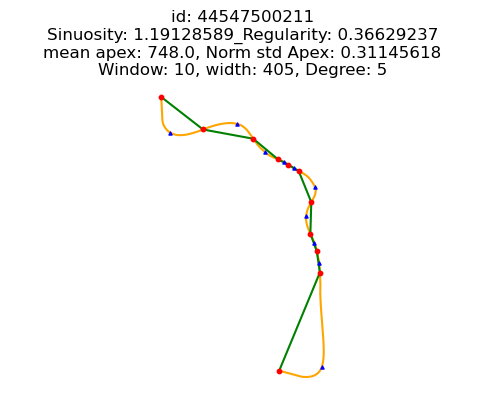

0.687845201303508


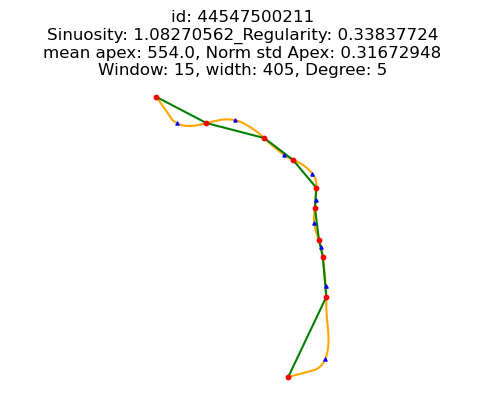

0.4509911261734624


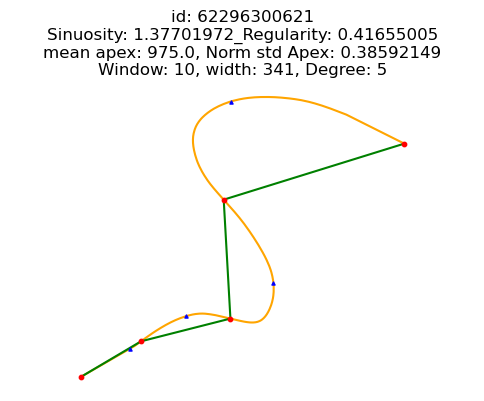

1.731594494499228


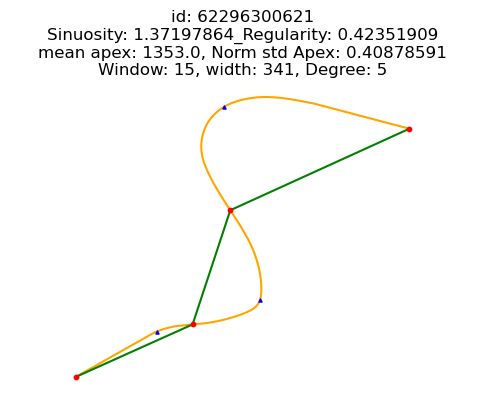

1.778058477500011


In [108]:
ids = [44547500211, 62296300621]
projection     = 'EPSG:3857'
s = 10
degree = 2
for id in ids:
    A = inflection_points_test(id, df, df_node,projection, plot = True, s = 10, degree = 5, end_points = True)
    A = inflection_points_test(id, df, df_node,projection, plot = True, s = 15, degree = 5, end_points = True)
